# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify paramter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples.

In [1]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 10 #Number of trajectories
nT = 50 #number of timepoints
noise_std = 0.2 #Standar deviation of the guassian noise added onto the measurements

MultipleTimepoints = True #Different timepoints for each trajectory?
timepoint_list = []
# timepoints = np.linspace(np.random.randint(0, 10), np.random.randint(10, 100), nT)
timepoints = np.linspace(0, 100, nT)
#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial conditions for each trajectory?

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = True)
    R.append(r)
    noisy_data = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    data.append(noisy_data)

M_original = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
M_original.write_bioscrape_xml('models/toy_model.xml')


### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

Sample log-like: 3762.33456944087
Sample log-like: 3771.9275668455048
Sample log-like: 3771.4692348846083
Sample log-like: 3772.560661107399
Sample log-like: 3774.630343325662
Sample log-like: 3765.3483263917287
Sample log-like: 3767.1368922194856
Sample log-like: 3766.273972941268
Sample log-like: 3771.566545531996
Sample log-like: 3770.663046749411
Sample log-like: 3763.3535570792183
Sample log-like: 3760.476594192093
Sample log-like: 3769.487821901883
Sample log-like: 3768.5786197781604
Sample log-like: 3773.322880045232
Sample log-like: 3769.006868296504
Sample log-like: 3767.3482165023247
Sample log-like: 3768.9682539138666
Sample log-like: 3768.291368548656
Sample log-like: 3769.5194653818853
Sample log-like: 3769.980653039762
Sample log-like: 3764.8339621871805
Sample log-like: 3760.674786901765
Sample log-like: 3766.6477258950827
Sample log-like: 3772.593447696476
Sample log-like: 3769.396028331
Sample log-like: 3762.935372938902
Sample log-like: 3772.1681748939172
Sample log-l

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


0.0 percent complete
0.5 percent complete
1.0 percent complete
1.5 percent complete
2.0 percent complete
2.5 percent complete
3.0 percent complete
3.5 percent complete
4.0 percent complete
4.5 percent complete
5.0 percent complete
5.5 percent complete
6.0 percent complete
6.5 percent complete
7.0 percent complete
7.5 percent complete
8.0 percent complete
8.5 percent complete
9.0 percent complete
9.5 percent complete
10.0 percent complete
10.5 percent complete
11.0 percent complete
11.5 percent complete
12.0 percent complete
12.5 percent complete
13.0 percent complete
13.5 percent complete
14.0 percent complete
14.5 percent complete
15.0 percent complete
15.5 percent complete
16.0 percent complete
16.5 percent complete
17.0 percent complete
17.5 percent complete
18.0 percent complete
18.5 percent complete
19.0 percent complete
19.5 percent complete
20.0 percent complete
20.5 percent complete
21.0 percent complete
21.5 percent complete
22.0 percent complete
22.5 percent complete
23.0 per

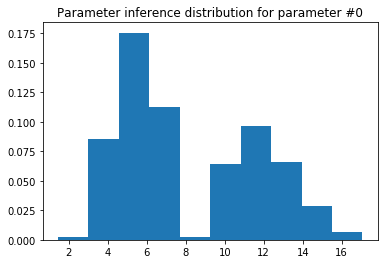

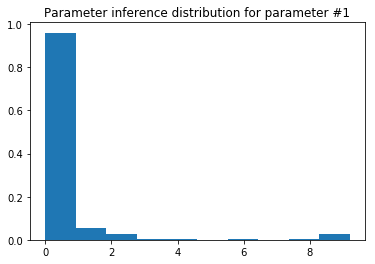

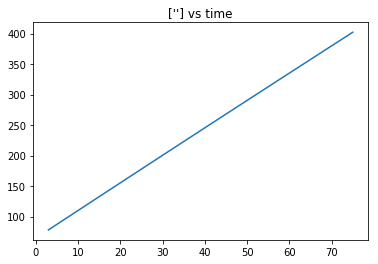

In [2]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = np.array(data)
pid.M = M
pid.prior = {'k1' : ['uniform', 1e-2, 1e4],'d1' : ['uniform', 1e-3, 1e3]}
pid.params_to_estimate = {'k1':10, 'd1':0.2}
pid.type = 'deterministic'
pid.timepoints = timepoint_list
pid.initial_conditions = X0_list
pid.nsamples = 500
pid.nsteps = 200
pid.nwalkers = 100
fitted_model, params = pid.run_mcmc(plot_show = True, progress = False)

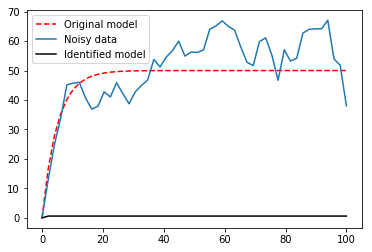

In [14]:
sim_x = py_simulate_model(timepoints, Model = M_original, stochastic = False)
sim_x_inf = py_simulate_model(timepoints, Model = fitted_model, stochastic = False)
plt.plot(timepoints, sim_x['X'], 'r--', label = 'Original model')
plt.plot(timepoints, noisy_data, label = 'Noisy data')
plt.plot(timepoints, sim_x_inf['X'], 'k', label = 'Identified model')

plt.legend()

In [ ]:
import pandas as pd
# Write noisy data to csv
# df = pd.concat(R)
file_name = 'test_data.csv'
R[0].to_csv(file_name, sep='\t', header = True)